# 🌐 Wikipedia recommender system
- Zuzanna Gawrysiak 148255
- Agata Żywot 148258

### Description (straight from ekursy - to be deleted later)


The general task is to create a system that will recommend similar articles based on the previously visited articles.

**Input - Collection of articles (links or titles), Output - Collection of recommended articles (links or titles) with a "score"**


You will receive a grade for each of the following steps. The highest possible score without
finishing all parts is 4.0. For example, if you do perfectly the first two steps your grades will be 4.0,
4.0, 2.0.


**Crawling and scraping** - Download text from at least 1000 Wikipedia/fandom wiki articles.
(Scrappy is not a must)


**Stemming, lemmatization** - preprocess downloaded documents into the most suitable form for this
task. Store it as a .csv/parquet file or into a database.


**Similarities** - for a given collection of previously visited articles find the best matches in your
database and recommend them to the user


GUI not required, notebook or any other reasonable form will be accepted. I have to be able to
provide a list of articles in an easy way and receive a meaningful recommendation.
You have to send the source code and report.


Report:
- pdf or notebook
- explain each step of your algorithm, especially how you score articles
- present interesting statistics about your database (most frequent words, histograms, similarities
between documents, ...)
- show some examples of recommendations with explanations (I'd prefer graphical form - see
prediction breakdowns for example)

## Import necessary libraries

In [1]:
from tqdm import tqdm
from time import sleep
import random
import re
import requests
import bs4

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.spatial.distance import cosine
from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.sklearn

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

c:\Users\zgawrysi\Anaconda3\envs\data-mining\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zgawrysi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zgawrysi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zgawrysi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Scraping wikipedia articles

Scraping the articles using BFS method. As a 'starter word' we chose 'Google'.

In [2]:
def getText(url):
    response = requests.get(url)
    assert(response.status_code == 200)
    parsed = bs4.BeautifulSoup(response.text)
    output = ""
    for p in parsed.select('p'):
      output += p.getText()
    return output

Stemming and other preprocessing methods combined into one function.

In [3]:
def preprocess(article):
    """
    Tokenize given article, remove stopwords, numbers, then perform stemming
    """
    preprocessed = []
    porter = PorterStemmer()
    tokenized = word_tokenize(article)
    sw = stopwords.words('english')

    for word in tokenized:
        if word.isalpha() and word not in sw:
            preprocessed.append(porter.stem(word))
    return ' '.join(preprocessed)

In [5]:
N = 1000
df = pd.DataFrame({'url':[], 'body':[]})

Preprocessing happens along scraping and the final results are saved to `csv` file.

In [6]:
def bfs(link):
    to_visit = [link]
    visited = set()
    pbar = tqdm(desc='Scraping', total=N)
    while (len(to_visit) != 0 and len(visited) < N):
        value = np.random.randint(1, 100)
        sleep(random.random()*3)
        url = to_visit.pop(0)
        if url not in visited:
            response = requests.get(url)

            if response.status_code == 200:
                visited.add(url)
            else:
                # print("Error: ", response.status_code, url)
                continue

            parsed = bs4.BeautifulSoup(response.text)
            body = ""
            for p in parsed.select('p'):
                body += p.getText()

            df.loc[len(df.index)] = [url, preprocess(body)]

            links = parsed.find_all('a', attrs={'href': re.compile(r'^/wiki')})
            random.shuffle(links)

            for l in links:
                pos = l.text.find('(')
                if pos >= 0:
                    to_visit.append(
                        "https://en.wikipedia.org/wiki/" + l.text[:pos-1])
                else:
                    to_visit.append("https://en.wikipedia.org/wiki/" + l.text)
        pbar.update(1)
    pbar.close()
    df.to_csv('./data/articles2.csv', encoding='utf-8', index=False)


In [ ]:
bfs('https://en.wikipedia.org/wiki/Google')

## Database analysis

In [4]:
df = pd.read_csv('./data/articles_google.csv')
df.head(10)

,url,body
0,https://en.wikipedia.org/wiki/Google,googl llc listen american multin technolog com...
1,https://en.wikipedia.org/wiki/Dunant,dunant may refer
2,https://en.wikipedia.org/wiki/Googleplex,the googleplex corpor headquart complex googl ...
3,https://en.wikipedia.org/wiki/Cisco,cisco system commonli known cisco multin digit...
4,https://en.wikipedia.org/wiki/YouTuber,a youtub onlin person influenc produc video pl...
5,https://en.wikipedia.org/wiki/AOL,aol styliz formerli compani known aol origin k...
6,https://en.wikipedia.org/wiki/Tenor,a tenor type classic male sing voic whose voca...
7,https://en.wikipedia.org/wiki/YouTube,youtub american onlin video share social media...
8,https://en.wikipedia.org/wiki/Pimp My Search,pimp my search novelti websit creat googl look...
9,https://en.wikipedia.org/wiki/Largest software...,mani list exist provid overview larg softwar c...


### Count vector
Store articles as numbers of occurences of words.

In [5]:
CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')
CountData = CountVec.fit_transform(df.body)
 
CountData

<1000x51403 sparse matrix of type '<class 'numpy.int64'>'
	with 507359 stored elements in Compressed Sparse Row format>

In [6]:
pd.set_option('display.max_columns', 1000)
dfCV = pd.DataFrame(CountData.toarray(), columns=CountVec.get_feature_names_out(), index=df.url)
dfCV

,aa,aaa,aaaa,aaai,aab,aaba,aaberg,aac,aachen,aacta,aadhaar,aadhar,aadmi,aafc,aafln,aalborg,aaliyah,aalto,aam,aap,aapl,aaqib,aar,aardoli,aardvark,aarhu,aaron,aaronson,aarp,aarti,aarunya,aashirvachana,aasivissuit,aav,ab,aba,ababa,abaca,abaceria,abacu,abajo,abakanowicz,abando,abandoibarra,abandon,abang,abangan,abanto,abanyagasimbo,abao,abap,abarth,abas,abat,abatimbo,abaza,abb,abba,abbadi,abbadid,abbasid,abbey,abbi,abbot,abbotsburi,abbott,abbr,abbrev,abbrevi,abc,abcd,abd,abdalla,abdel,abdic,abdomen,abdomin,abdu,abduct,abduh,abdul,abdullah,abdülhamid,abe,abeb,abel,abelian,abendblatt,abengoa,aberdeen,abernathi,aberr,aberta,aberystwyth,abet,abg,abgad,abhijit,abhijñānaśākuntalam,abhorr,abi,abid,abidesinin,abidin,abierta,abierto,abigail,abijo,abil,abildgaard,abilen,abiogenesi,abiot,abitur,abjad,abjadi,abjur,abkhaz,abl,ablaz,ableism,abli,abn,abnorm,aboard,abod,abolish,abolit,abolition,abolitionist,abomin,abond,aborigin,abort,abosch,abound,aboutaleb,abov,aboveground,abovement,abq,abqaiq,abrad,abraham,abram,abramson,abras,abravanel,abrazo,abreast,abreu,abridg,abril,abroad,abrog,abrupt,abruptli,abruzzo,absalon,absenc,absent,absente,absolu,absolut,absolutist,absolv,absorb,absorpt,abstain,abstracion,abstract,abstraction,abstractli,absurd,absurdist,abt,abtracetogeth,abu,abuelo,abugida,abuja,abukhalil,abund,abundantli,aburto,abus,abushiri,abut,abw,abx,abydo,abyssinia,abzug,ac,aca,acab,acacia,academ,academi,academia,academician,acadian,académi,acalan,acan,acanthamoeba,acanthocephalan,acapulco,acar,acarajé,acatlán,acb,acc,acca,accademia,accademici,accavallo,accc,acced,accel,acceler,accelerando,acceleromet,accent,accentu,accentur,accept,acceptor,access,accessori,accid,accident,acciona,acclaim,acclim,acclimat,accolad,accommod,accompani,accompli,accomplish,accord,accordingli,accordion,account,accountguard,accourd,accra,accredit,accret,accru,accrual,accultur,accumul,accur,accuraci,accus,accusound,accustom,accuweath,acd,ace,aceh,acel,acela,acer,acet,acetylcholin,acetylen,acetylid,acevedo,acf,acftu,achaea,achaean,achaemenid,achamm,achar,achernartek,acheron,achi,achiev,achil,achomi,achromat,achromatopsia,achronix,achúcarro,acid,acidif,acitrón,acker,acknowledg,ackroyd,acland,aclu,acm,acma,acmeist,acn,acolman,aconcagua,acorn,acosta,acousmat,acoust,acquaint,acquiesc,acquir,acquisit,acquit,acquitt,acqusit,acr,acra,acreag,acred,acrimoni,acrisur,acro,acrobat,acroni,acronym,acrophoni,acropoli,acryl,act,acta,actcanberra,actel,actewagl,action,actionaid,actionnot,actionscript,activ,activa,activeiq,activemedia,activex,activis,activist,acto,actopan,actor,actress,actual,actuari,actuat,actueel,actuel,acuiti,acumen,acura,acut,acuvu,acycl,acyl,ad,ada,adac,adag,adagamov,adagrad,adalbert,adalberto,adam,adamian,adamsii,adamson,adamów,adand,adani,adapt,adaptv,adat,adb,adbird,adblock,adc,adchoic,adcock,add,addaura,addenda,addendum,adder,addi,addict,addington,addiscod,addit,addon,address,adduct,ade,adea,adecco,adedeji,adel,adelaid,adelek,adelphi,adelson,aden,adena,adenau,adenosin,adentro,adept,adequ,adequaci,adero,adesto,adeven,adevinta,adexchang,adf,adhd,adhemar,adher,adhes,adhiparasakthi,adi,adiabat,adida,adif,adig,adigrat,adil,adin,adirondack,aditya,adium,adjac,adjay,adject,adjectiv,adjoin,adjud,adjudg,adjudicatori,adjunct,adjust,adl,adlai,adlam,adlan,adler,admbook,admedia,admin,administ,administr,administración,admir,admira,admiralti,admiss,admit,admittedli,admixtur,admob,admonit,adnan,adnoc,ado,adob,adolesc,adolf,adolfo,adolph,adolphu,adoni,adopt,ador,adoratric,adorn,adorno,adp,adpocalyps,adress,adria,adriaan,adrian,adrianopl,adriat,adrien,adrienn,adrián,adsens,adserv,adsl,adsorb,adss,adt,adtech,aduba,adult,adultcentr,...,étang,étendard,étienn,étude,évian,évora,ímaz,índice,íñigo,île,ðel,ñubl,óbido,öcalan,öffentlichkeit,ögel,ölüdeniz,ösi,österreich,österreichisch,österreichr,östringen,ötzi,övp,özal,özlem,özpetek,öğrenci,økėÿ,øresund,ørsted,østerild,østerskær,øyenstikk,øystein,único,úrsula,ústí,úzsi,über,ünver,üzletág,þe,þeodisc,þeudō,þic,þicc,þiudiskaz,þæt,ālǐyún,āryabh

### Most frequent words

Top five most frequent words:
use        9091
googl      8459
compani    6878
includ     6651
state      6485
dtype: int64


<AxesSubplot:title={'center':'Most frequent words'}>

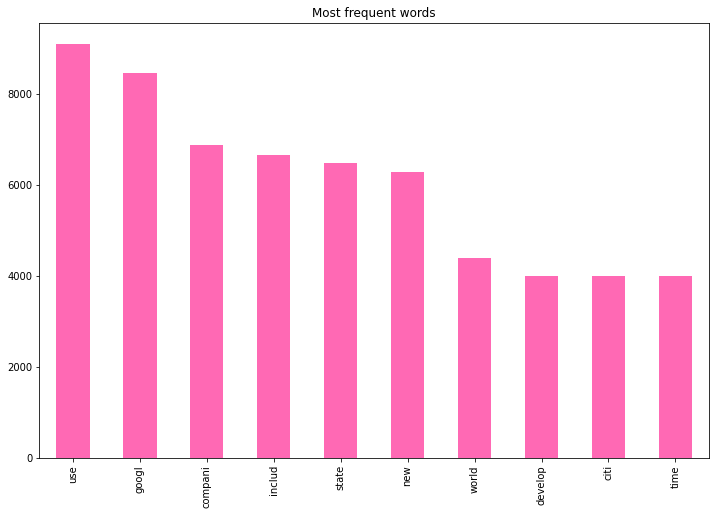

In [10]:
word_sums = dfCV.sum(axis=0)
word_sums = word_sums.sort_values(ascending=False)
# print(word_sums)
print(f"Top five most frequent words:\n{word_sums[:5]}")
word_sums[:10].plot(kind='bar', figsize=(12,8), title="Most frequent words", color='hotpink')


All words as a wordcloud

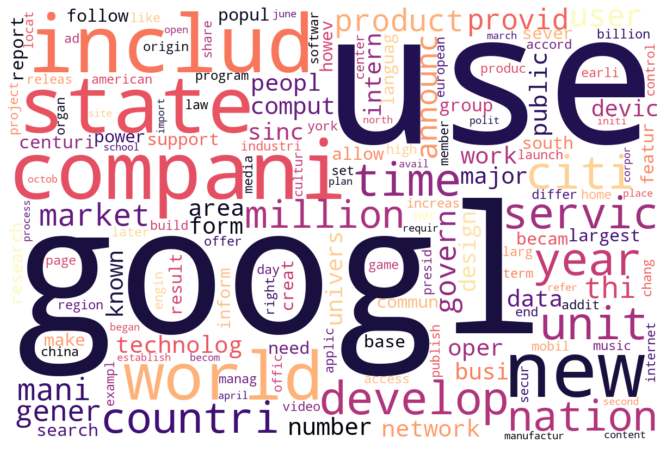

In [11]:
def generate_wordcloud(data):
    wc = WordCloud(width=1200, height=800, max_words=150, background_color='white', colormap='magma').generate_from_frequencies(data)
    plt.figure(figsize=(12,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

generate_wordcloud(word_sums)

### Similarities between documents

Check the similarities using LDA (Latent Drichlet Allocation). 

In [12]:
lda_tf = LatentDirichletAllocation(n_components=10, random_state=0) # number of articles
lda_tf.fit(CountData)

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_tf, CountData, CountVec, mds='tsne')
panel

c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\ag

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1  18.387860
8       0.648955  71.707100       2        1  15.196636
6      71.019684   9.971006       3        1  13.595094
2       3.785981  33.185135       4        1  10.473739
1     -42.666500  -9.222070       5        1  10.028346
4      -3.621689 -43.526516       6        1   9.441322
9      -3.632402  -4.171708       7        1   7.192803
3     -36.584400  35.804413       8        1   5.832419
5      44.391380  50.615383       9        1   5.132936
7      40.235809 -31.591665      10        1   4.718844, topic_info=          Term         Freq        Total Category  logprob  loglift
17948    googl  8178.000000  8178.000000  Default  30.0000  30.0000
8265      citi  3856.000000  3856.000000  Default  29.0000  29.0000
8988   compani  6648.000000  6648.000000  Default  28.0000  28.0000
11519    devic  2092.000000  2092.000000  Default  27.0000  27.0000
47515     user  3045.000000  3045.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
30407   nation   262.747280  3480.913109  Topic10  -5.4975   0.4697
50237     year   265.916212  3790.283743  Topic10  -5.4855   0.3966
33871    peopl   230.373151  2258.277711  Topic10  -5.6290   0.7709
35171    popul   198.196255  2038.717416  Topic10  -5.7794   0.7228
7417   centuri   192.653266  2056.646302  Topic10  -5.8078   0.6857

[821 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
91         3  0.962510     aberr
225        2  0.094347  accentur
225       10  0.896299  accentur
228        1  0.282095    access
228        2  0.498153    access
...      ...       ...       ...
50667      1  0.059531      ziff
50667     10  0.922724      ziff
50764      2  0.102164       zte
50764      7  0.868391       zte
50764      9  0.030649       zte

[3292 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 7, 3, 2, 5, 10, 4, 6, 8])

### Conclusions from analysis
* The most frequent word is 'use', followed by 'google'.
* Above graph can be used to examine similarities between documents and the frequencies of terms

## TFIDF approach
Count vector was for showing some interesteing statistics, but for the recommendation we will use TFIDF.

In [7]:
tfidf = TfidfVectorizer(ngram_range=(1,1), use_idf=True, smooth_idf=False, stop_words='english') 
tfidf_data = tfidf.fit_transform(df.body) 
dfTFIDF = pd.DataFrame(tfidf_data.toarray(), index=df.url, columns=tfidf.get_feature_names_out())
dfTFIDF

aa  aaa  aaaa  aaai  aab  \
url                                                                             
https://en.wikipedia.org/wiki/Google                0.0  0.0   0.0   0.0  0.0   
https://en.wikipedia.org/wiki/Dunant                0.0  0.0   0.0   0.0  0.0   
https://en.wikipedia.org/wiki/Googleplex            0.0  0.0   0.0   0.0  0.0   
https://en.wikipedia.org/wiki/Cisco                 0.0  0.0   0.0   0.0  0.0   
https://en.wikipedia.org/wiki/YouTuber              0.0  0.0   0.0   0.0  0.0   
...                                                 ...  ...   ...   ...  ...   
https://en.wikipedia.org/wiki/grassroots campaign   0.0  0.0   0.0   0.0  0.0   
https://en.wikipedia.org/wiki/Android Debug Bridge  0.0  0.0   0.0   0.0  0.0   
https://en.wikipedia.org/wiki/Yandex                0.0  0.0   0.0   0.0  0.0   
https://en.wikipedia.org/wiki/carbon neutrality     0.0  0.0   0.0   0.0  0.0   
https://en.wikipedia.org/wiki/Doodle                0.0  0.0   0.0   0.0  0.0   

                                                    aaba  aaberg  aac  aachen  \
url                                                                             
https://en.wikipedia.org/wiki/Google                 0.0     0.0  0.0     0.0   
https://en.wikipedia.org/wiki/Dunant                 0.0     0.0  0.0     0.0   
https://en.wikipedia.org/wiki/Googleplex             0.0     0.0  0.0     0.0   
https://en.wikipedia.org/wiki/Cisco                  0.0     0.0  0.0     0.0   
https://en.wikipedia.org/wiki/YouTuber               0.0     0.0  0.0     0.0   
...                                                  ...     ...  ...     ...   
https://en.wikipedia.org/wiki/grassroots campaign    0.0     0.0  0.0     0.0   
https://en.wikipedia.org/wiki/Android Debug Bridge   0.0     0.0  0.0     0.0   
https://en.wikipedia.org/wiki/Yandex                 0.0     0.0  0.0     0.0   
https://en.wikipedia.org/wiki/carbon neutrality      0.0     0.0  0.0     0.0   
https://en.wikipedia.org/wiki/Doodle                 0.0     0.0  0.0     0.0   

                                                    aacta  aadhaar  aadhar  \
url                                                                          
https://en.wikipedia.org/wiki/Google                  0.0      0.0     0.0   
https://en.wikipedia.org/wiki/Dunant                  0.0      0.0     0.0   
https://en.wikipedia.org/wiki/Googleplex              0.0      0.0     0.0   
https://en.wikipedia.org/wiki/Cisco                   0.0      0.0     0.0   
https://en.wikipedia.org/wiki/YouTuber                0.0      0.0     0.0   
...                                                   ...      ...     ...   
https://en.wikipedia.org/wiki/grassroots campaign     0.0      0.0     0.0   
https://en.wikipedia.org/wiki/Android Debug Bridge    0.0      0.0     0.0   
https://en.wikipedia.org/wiki/Yandex                  0.0      0.0     0.0   
https://en.wikipedia.org/wiki/carbon neutrality       0.0      0.0     0.0   
https://en.wikipedia.org/wiki/Doodle                  0.0      0.0     0.0   

                                                    aadmi  aafc  aafln  \
url                                                                      
https://en.wikipedia.org/wiki/Google                  0.0   0.0    0.0   
https://en.wikipedia.org/wiki/Dunant                  0.0   0.0    0.0   
https://en.wikipedia.org/wiki/Googleplex              0.0   0.0    0.0   
https://en.wikipedia.org/wiki/Cisco                   0.0   0.0    0.0   
https://en.wikipedia.org/wiki/YouTuber                0.0   0.0    0.0   
...                                                   ...   ...    ...   
https://en.wikipedia.org/wiki/grassroots campaign     0.0   0.0    0.0   
https://en.wikipedia.org/wiki/Android Debug Bridge    0.0   0.0    0.0   
https://en.wikipedia.org/wiki/Yandex                  0.0   0.0    0.0   
https://en.wikipedia.org/wiki/carbon neutrality       0.0   0.0    0.0   
https://en.wikipedia.org/wiki/Doodle      

## Recommender system - similarities

Recommendations are made together with graphs showing the most frequent words, what nicely explains why specific answears were provided by the system. The provided method works in two modes: 
* 'query' for some words input (like a title)
* 'url' for list of url links

In [8]:
def preprocess_user_input(user_data, mode='query'):
    if mode == 'query':
        if isinstance(user_data, list):
            user_data = ' '.join(user_data)
        query = preprocess(user_data)

    elif mode == 'url':
        if isinstance(user_data, list):
            query = ''
            for url in user_data:
                query = query + ' ' + preprocess(getText(url))

        else:
            query = preprocess(getText(url))

    if query is None:
        return None

    return query


In [9]:
def get_recommendations(df, user_data, mode='query', n=10):
    tfidf = TfidfVectorizer(ngram_range=(
        1, 1), use_idf=True, smooth_idf=False, stop_words='english')
    tfidf.fit_transform(df.body)
    query = preprocess_user_input(user_data, mode)
    if query is None:
        return None

    query = tfidf.transform([query]).toarray()[0]
    res = 1-dfTFIDF.apply(lambda x: cosine(x, query), axis=1).sort_values()[:n]
    res = res.reset_index()
    res = res.rename(columns={0: "score"})
    res['title'] = res['url'].str.replace('https://en.wikipedia.org/wiki/', '', regex=True)
    return res[['title', 'url', 'score']]


In [24]:
def get_statistics(dfCV, result_url, user_data, mode='query', n=5):
    res = dfCV.iloc[dfCV.index.get_loc(result_url)]
    res = res.sort_values(ascending=False)[:n]

    query = preprocess_user_input(user_data, mode)
    CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')
    if mode == 'query':
        query = [query, '']
    elif mode == 'url':
        query = [query]
    CountData = CountVec.fit_transform(query)

    dfCV_query = pd.DataFrame(CountData.toarray(), columns=CountVec.get_feature_names_out()).iloc[0]
    dfCV_query = dfCV_query.sort_values(ascending=False)[:n]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    dfCV_query.plot(kind='bar', title='USER DATA', ylabel='count', color='pink', ax=axes[0])
    res.plot(kind='bar', title=result_url, ylabel='count', color='deeppink', ax=axes[1])
    

In [11]:
QUERY = ['machine learning']
results_query = get_recommendations(df, QUERY)
print(f'Results recommended for the following query: {QUERY}')
print(results_query[['url', 'score']])

Results recommended for the following query: ['machine learning']
                                                 url     score
0     https://en.wikipedia.org/wiki/machine learning  0.692954
1          https://en.wikipedia.org/wiki/ML Fairness  0.428903
2  https://en.wikipedia.org/wiki/Artificial intel...  0.197716
3                   https://en.wikipedia.org/wiki/AI  0.197716
4  https://en.wikipedia.org/wiki/DeepMind Technol...  0.178145
5           https://en.wikipedia.org/wiki/TensorFlow  0.118878
6      https://en.wikipedia.org/wiki/Home appliances  0.107829
7  https://en.wikipedia.org/wiki/Google Cloud Pla...  0.093056
8          https://en.wikipedia.org/wiki/Rajen Sheth  0.086792
9            https://en.wikipedia.org/wiki/Chromebox  0.080561


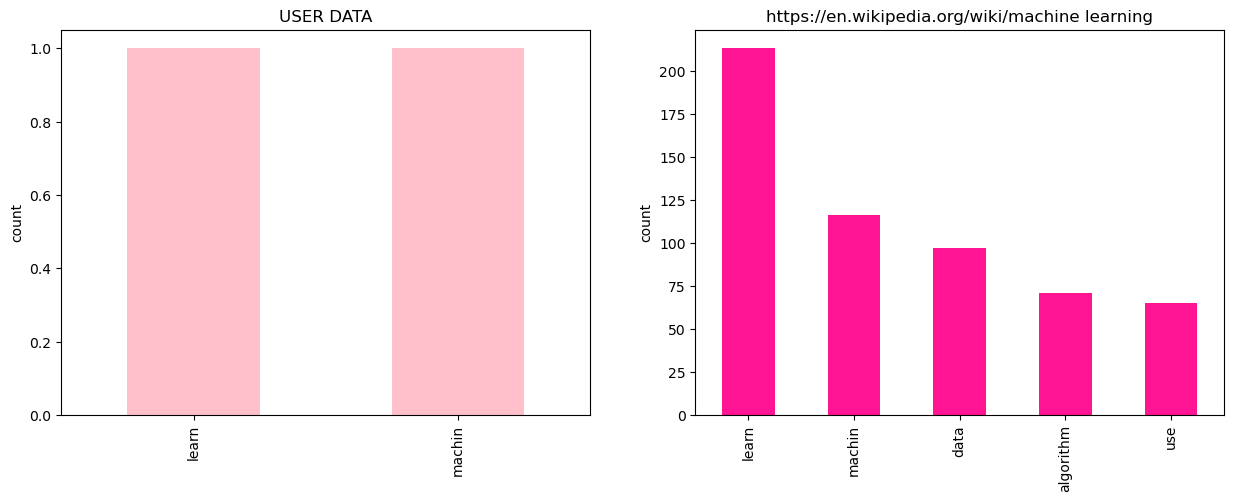

In [25]:
res = get_statistics(dfCV, results_query.iloc[0]['url'] , QUERY)
res

In [29]:
URL = ['https://www.primark.com/en-gb/about-us']
results_url = get_recommendations(df, URL, mode='url')
print(f'Results recommended for the following urls: {URL}')
print(results_url[['url', 'score']])

Results recommended for the following urls: ['https://www.primark.com/en-gb/about-us']
                                               url     score
0         https://en.wikipedia.org/wiki/e-commerce  0.206060
1           https://en.wikipedia.org/wiki/Shopping  0.200337
2        https://en.wikipedia.org/wiki/Marketplace  0.125906
3  https://en.wikipedia.org/wiki/carbon neutrality  0.100278
4          https://en.wikipedia.org/wiki/Datastore  0.082353
5                 https://en.wikipedia.org/wiki/UK  0.078865
6     https://en.wikipedia.org/wiki/United Kingdom  0.078865
7            https://en.wikipedia.org/wiki/Takeout  0.078692
8             https://en.wikipedia.org/wiki/Calico  0.077337
9      https://en.wikipedia.org/wiki/United States  0.074708


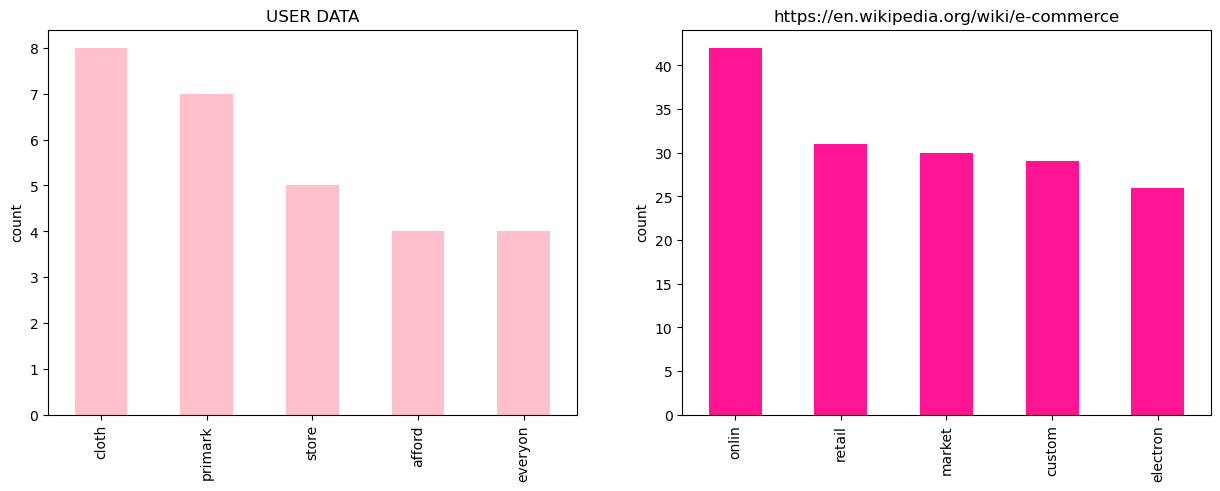

In [30]:
res = get_statistics(dfCV, results_url.iloc[0]['url'], URL, mode='url')
res

### Provide your query here 😊

Results recommended for the following urls: ['https://www.put.poznan.pl/en?q=', 'https://sin.put.poznan.pl/people/details/grzegorz.miebs']
                                                 url     score
0         https://en.wikipedia.org/wiki/Science Fair  0.163537
1              https://en.wikipedia.org/wiki/Science  0.151324
2        https://en.wikipedia.org/wiki/New York City  0.117194
3  https://en.wikipedia.org/wiki/Artificial intel...  0.109492
4                   https://en.wikipedia.org/wiki/AI  0.109492
5  https://en.wikipedia.org/wiki/Héctor García-Mo...  0.105405
6                  https://en.wikipedia.org/wiki/PhD  0.096250
7  https://en.wikipedia.org/wiki/National Autonom...  0.093712
8        https://en.wikipedia.org/wiki/Doodle4Google  0.091847
9       https://en.wikipedia.org/wiki/European Union  0.089608
None


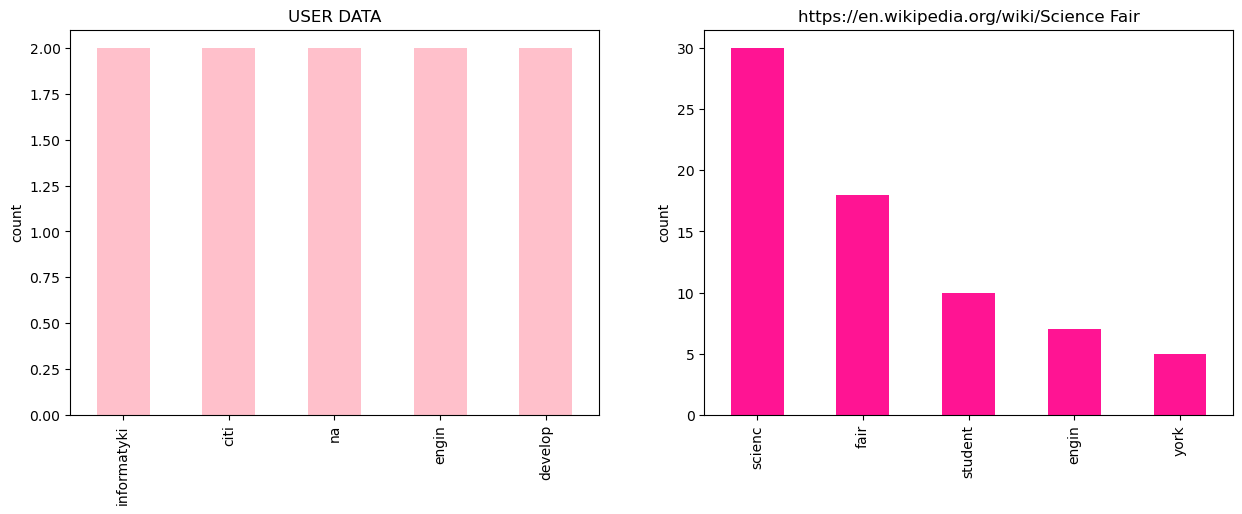

In [32]:
# urls
your_url = ['https://www.put.poznan.pl/en?q=', 'https://sin.put.poznan.pl/people/details/grzegorz.miebs'] #XD zmień to
results_url = get_recommendations(df, your_url, mode='url')
print(f'Results recommended for the following urls: {your_url}')
print(results_url[['url', 'score']])
print(get_statistics(dfCV, results_url.iloc[0]['url'], your_url, mode='url'))

Results recommended for the following query: ['I dont want a lot for Christmas There is just one thing I need']
                                                 url     score
0               https://en.wikipedia.org/wiki/Groups  0.103601
1           https://en.wikipedia.org/wiki/Comparison  0.080328
2   https://en.wikipedia.org/wiki/Internet of things  0.045193
3             https://en.wikipedia.org/wiki/software  0.034655
4             https://en.wikipedia.org/wiki/Software  0.034655
5           https://en.wikipedia.org/wiki/Larry Page  0.031273
6       https://en.wikipedia.org/wiki/Living Stories  0.030420
7      https://en.wikipedia.org/wiki/citation needed  0.030177
8  https://en.wikipedia.org/wiki/original program...  0.029180
9         https://en.wikipedia.org/wiki/Swedish Chef  0.025683
None


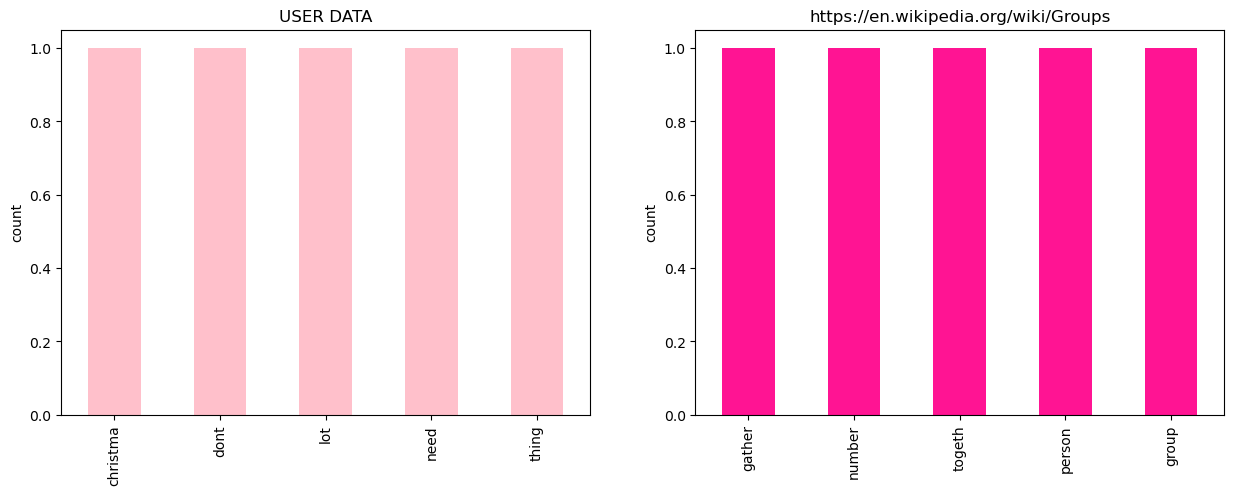

In [34]:
# titles
your_query = ['I dont want a lot for Christmas There is just one thing I need'] # to też xd
results_query = get_recommendations(df, your_query)
print(f'Results recommended for the following query: {your_query}')
print(results_query[['url', 'score']])
print(get_statistics(dfCV, results_query.iloc[0]['url'] , your_query))